# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
s=tf.InteractiveSession()
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.2.1


Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [2]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [15]:
# token expires every 30 min
COURSERA_TOKEN = ""
COURSERA_EMAIL = ""

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

 8642560/11490434 [=====================>........] - ETA: 0s

X_train [shape (50000, 28, 28)] sample patch:
 [[ 0.          0.29803922  0.96470588  0.98823529  0.43921569]
 [ 0.          0.33333333  0.98823529  0.90196078  0.09803922]
 [ 0.          0.33333333  0.98823529  0.8745098   0.        ]
 [ 0.          0.33333333  0.98823529  0.56862745  0.        ]
 [ 0.          0.3372549   0.99215686  0.88235294  0.        ]]
A closeup of a sample patch:


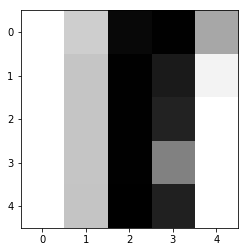

And the whole sample:


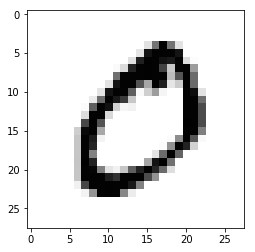

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [7]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]] [5 0 4]


In [18]:
# run this again if you remake your graph
s = reset_tf_session()

In [19]:
# Model parameters: W and b
W = tf.Variable(tf.random_normal(shape=[784,10],stddev=0.01),name='weights')
b = tf.Variable(tf.zeros([1,10]),name='bias')


In [20]:
# Placeholders for the input data
input_X = tf.placeholder(tf.float32,[None,784])### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder(tf.float32,[None,10])### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels

In [21]:
# Compute predictions
logits = tf.matmul(input_X,W) + b ### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits)### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = tf.argmax(probas,1)### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y,logits=logits))
                      ### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(0.01).minimize(loss)### YOUR CODE HERE ### optimizer step that minimizes the loss

                     
train_loss_results=[]
test_loss_results=[]
iteration_numbers=[]                

In [22]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAormPhz8bfgx8YbjV7T4R/F3wx4pl8P35sdfi8Oa/bXzabdAkGC4ELsYZAVb5Hw3B44rN8DftP/s0/FDXtb8K/DT9ofwN4i1Tw0Jj4j03QvFtnd3GlCKQxym5jilZoNkisjbwNrAg4IxQB3NFc58LfjD8JPjj4VXx38FPil4c8YaG1w8C6z4W1u31C0MqY3xiaB3TcuRlc5Gea6OgAooooAKKKKACiiigAooooAKKKKACiiigArz347ftSfBT9m%2BTRrH4peINTGo%2BIpZ00DQfDnhfUdc1TUfJVXneGx023nuZI4lZDJIsZSPem4ruXPoVeDftD/A/4%2Bf8NJ%2BDv2tv2bLLwfrWueH/AAdrHhTV/CnjnXLrS7S8sL%2B5sLsXEF7a2l49vPFNp6Aqbd1lSUglCitQAaX/AMFMv2LNYu/E9vafFe/SHwVayT%2BMtSu/BesQWOghLSK72Xl3LaLBaytDNGyQyOskhYqisysovaf/AMFD/wBkrUfAGtfEVPH%2Br28Hh/VrLS9V0TUPA2s2uuRXl5t%2BxwLo81ouoSvcBgYRHbt5oDFNwViPLZv2AfjL4x/Zr%2BOfw18YeKfCmkeKfij8VLfx1odzpTXF5YWl5bQ6LLBDciSKGSSI3elFHCjJgcYO4lVo%2BLv2L/2lfi5q/wAR/jl8bfhL8KNa8WeNbHwpo%2Bn%2BArL4jazZabp9jodxqV3DeprtvpqXkOoNc6pM6SxWg8lIo0VmJZyAey%2BIf2%2B/2bPC/hrw54j1e%2B8beZ4rS/k0Tw/a/CbxJca5JFZSxxXc0mkxae1/bwwvNCryzQIimaLLfvEz6ZrPxE8EeG/h7dfFfxP4lttK8OWOjvqt/q%2Bqt9lhtLJIjM88xl2%2BUqxgs2/G0A5xg18YeKf2Ef2z9Y%2BBfhfw1rLeF/FXjvRrnxEdF8ZX/wAdvE2kav4Itb65SS0s7XWrWwkvNchiSOETLerD9pNtF5gIUY9R%2BNH/AATotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/wCClH7GX/CufFfxW1j4rXuiaN4IsrK%2B8UP4n8HavpNzZWV5MYbW9%2By3lrFcSWksiuqXMcbQt5bkPhGI4/43f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv/ANqH9gz40/GD4g/F/wCIPgXxD4Xjk8XwfC288JWerX1zEr3/AIT8R3OtSw3jR28nkQ3Aa3hWWMTOuXYx/IquAeoWH/BQT9lvUfibZfBmHxP4mj8V3mi6frEugXfw316C507T71p0gu79JLJTp0O63lV5LryliIUSFC6bqPhr/gph%2BxT4t8GeLPiFpHxguE0fwX4IuvGWsXuoeEtVtBceHrdGebVrFZ7VG1SzVUOJ7MTxsWQKxLoGwdD/AGQ/ih8Q/iZ8bviD8b18PaDF8aPg74d8IXVj4T1241GXS7i0TXUu2WeeztfNjA1WIxPsVmKSbo48Dd83ftjfsqftQ6P%2Bwx8Uvib%2B0xd%2BALSH4Q/sU/EHwR4Xj8BaheXDa817pFsZ9RulubaAWKhNItwlnG1wFaaQmdtqCgD6z8Pf8FJf2MvE2h6x4j0/4tXUFnoaaVNfyap4S1WyZrTUrtbOx1CFLi1RrmwlnYKL6EPaqAztKqKzD0/RPi78PPEfxS1/4L6H4h%2B0%2BJPC2l6fqGv2EdpNts4L5rgWu6Yp5Rd/ssx8tXMiqEZlVZIy3yTqH7M/iDxXoHin42/8FIvF/wAM/CfgW3/Z7ufh1JceH/EEy2sum3skMl5qt5NewW6WDkwWwhtkMwgJk/0iQsuOw/4I%2BeA/i7Z/sj2vx/8A2kNQN/8AEn4vXkfifxXqD2clu0kItILLTV8qX54f%2BJfaWkjRNgpLNNkBi2QD6qooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArxHSP%2BCjH7HupXevWep/FK88PN4c8OXPiDUJPGvhHVdBjm0m3dI57%2B1k1K1gW%2Bt0eSJWltjKgMsYzl1z7TexXM1nLDZ3QgmeJlimMe/wAtiOG2nrg8471%2BYmr/APBHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/AG//ANmG1%2BGjfFjWPEHirStLbXINGsbPXPhlr9hqmp38yGSGCy024sUvb9pEDOv2eGQMqOwJCMR0XgP9qz4H/EfX7Lwn4c8Q6pDq9/4Un8SQ6RrXhXUtMu002G7%2BySyyw3lvFJA6z/IYZFWXvs2815N8Tvg5%2B278Ym%2BHvxt1zwb8KtD%2BIfwo8dTax4f8M2vjjUr/AEXXLO40m70y5juL59KhmsZil7JJG6WtwIzEFPmCRsVfiT8Bv24Nf%2BMvh39prwPo3wrtPFl98MNV8F%2BMdC1LxXqUlhpC3F/DdWt/ZXCacJNQMQjdZLeWK0EpcYlixyAdxpP/AAUb/ZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ONZ8eeIPDV2fB37KXhH4Y376Rczys2raW8zXM0XmQR7rVt6bGYq7bfmjTArxr4af8Eq/2xvE/wAUfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v8AiTWrzxFLq9ilt/adrpl9DHp%2BhHKljaWilFyoEziNVoA%2BpfCf/BRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/8ABPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2Ga

# Submit a linear model

In [23]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [24]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Adding more layers

Let's add a couple of hidden layers and see how that improves our validation accuracy.

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convinient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (rememeber that we need it for a hidden layer!).

Now add 2 hidden layers to the code above and restart training.
You're aiming for ~0.97 validation accuracy here.

In [11]:
# you can write the code here to get a new `step` operation and then run cells with training loop above
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety
### YOUR CODE HERE ###

hidden1=tf.layers.dense(input_X,256,activation=tf.nn.sigmoid)
hidden2=tf.layers.dense(hidden1,256,activation=tf.nn.sigmoid)
logits=tf.layers.dense(hidden2,10)
probas=tf.nn.softmax(logits)
classes=tf.argmax(probas,1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y,logits=logits))
step = tf.train.AdamOptimizer(0.01).minimize(loss)
s.run(tf.global_variables_initializer())


# Submit a 2-layer MLP
Run these cells after training a 2-layer MLP

In [13]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [17]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
